In [1]:
from shapely.geometry import MultiPolygon
import matplotlib.pyplot as plt
from geospatial_optimization import optimize_sensor_placement, calculate_coverage_info, plot_sensor_map, export_to_geojson

# This area is defined by a set of polygons representing the operational boundaries.
operational_area = MultiPolygon(
    [
        [[
            (-0.18524, 51.50985),
            (-0.17645, 51.51081),
            (-0.17653, 51.50913),
            (-0.17527, 51.50735),
            (-0.1734, 51.50587),
            (-0.17477, 51.50388),
            (-0.17516, 51.503),
            (-0.17505, 51.502),
            (-0.18069, 51.50177),
            (-0.18211, 51.50495),
            (-0.18101, 51.50569),
            (-0.18152, 51.50707),
            (-0.18608, 51.50706),
            (-0.18736, 51.50967),
        ],[]],
        [[
            (-0.17117, 51.5111),
            (-0.16986, 51.51037),
            (-0.16954, 51.50741),
            (-0.17018, 51.50646),
            (-0.16905, 51.50618),
            (-0.16364, 51.50619),
            (-0.15898, 51.50515),
            (-0.15314, 51.50407),
            (-0.15237, 51.50553),
            (-0.15499, 51.50819),
            (-0.15816, 51.51001),
            (-0.15898, 51.51206),
            (-0.16128, 51.51195),
            (-0.16504, 51.51187),
            (-0.17073, 51.51134),
        ],[]],
        [[
            (-0.17103, 51.50469),
            (-0.17181, 51.50372),
            (-0.17177, 51.50236),
            (-0.16108, 51.50265),
            (-0.16106, 51.50371),
        ],[]],
    ]
)

In [2]:
configurations=[]

# Define azimuths in degrees
# These azimuths represent the directions in which the sensors will be oriented
azimuths = [0.0, 22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0, 202.5, 225.0, 247.5, 270.0, 292.5, 315.0, 337.5]

# Generate configurations for each azimuth with different fan degrees and ranges
for a in azimuths:
    configurations.append(    
        {
            'azimuth_degree': a,
            'fan_degree': 50,
            'range_km': 0.4,
        } 
    )
    configurations.append(    
        {
            'azimuth_degree': a,
            'fan_degree': 90,
            'range_km': 0.3,
        } 
    )
    configurations.append(    
        {
            'azimuth_degree': a,
            'fan_degree': 130,
            'range_km': 0.2,
        } 
    )

In [3]:
status, placed_sensors_info = optimize_sensor_placement(
    operational_area=operational_area,
    configurations=configurations,
    resolution_km=0.15,
    max_sensors=99,
    coverage_requirement=0.8,
    encourage_overlapping=0.0,
)
print(f"Status: {status}")

info = calculate_coverage_info(
    operational_area=operational_area, 
    placed_sensors=placed_sensors_info, 
    resolution_km=0.15
)
print(f"Number of sensors placed: {info['num_sensors']}")
print(f"Estimated coverage percentage: {info['estimated_coverage_percent']*100:.2f}%")
print(f"Actual Area Coverage: {info['actual_coverage_percent']*100:.2f}%")

Status: Optimal
Number of sensors placed: 13
Estimated coverage percentage: 80.00%
Actual Area Coverage: 56.28%


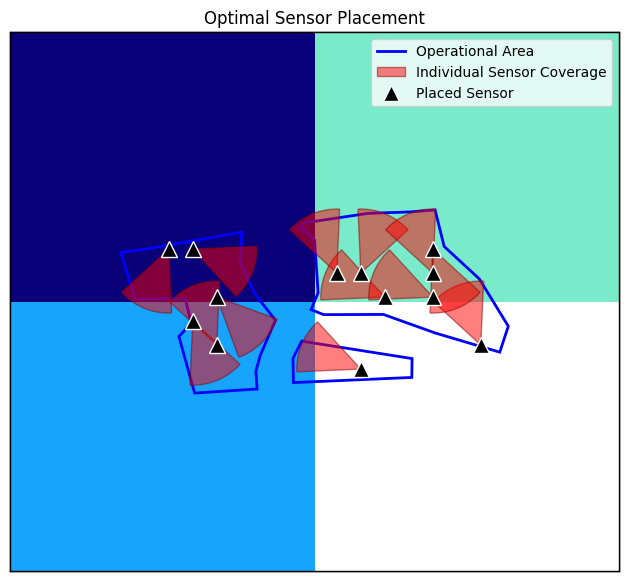

In [4]:
ax = plot_sensor_map(operational_area, placed_sensors_info, plot_margin=0.01)
plt.show()

In [5]:
output_filename = "sensor_placement.geojson"

# Call the export function
export_to_geojson(
    filename=output_filename,
    op_area=operational_area,
    placed_sensors=placed_sensors_info,
)